In [1]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append('..')

In [2]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

from utils.dataLoaderSB import LandmarksDataset, ToTensor
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH

In [3]:
test_path = "../Datasets/Shenzhen/Prep" 

img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'Masks')

test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             ToTensor()])
                                 )

device = 'cuda:0'

In [4]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = 1024

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f
config['K'] = 6

hybrid = Hybrid(config, D_t, U_t, A_t).to(device)
hybrid.load_state_dict(torch.load("../weights/HybridGNet/best.pt"))
hybrid.eval()
print('Model loaded')

Model loaded


In [5]:
from models.pca import PCA_Net

config['extended'] = False
config['device'] = device

pcaNet = PCA_Net(config.copy()).to(device)
pcaNet.load_state_dict(torch.load('../weights/baselines/pca/best.pt'))
pcaNet.eval()
print('Model loaded')

Model loaded


In [6]:
from models.vae import VAE_Mixed

config['allOrgans'] = False

vae = VAE_Mixed(config.copy()).to(device)
vae.load_state_dict(torch.load('../weights/baselines/vae/best.pt'))
vae.eval()
print('Model loaded')

Model loaded


In [7]:
config['l1'] = 6
config['l2'] = 5
config['window'] = (3,3)

double65 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
double65.load_state_dict(torch.load("../Training/ds_prueba/bestMSE.pt"))
double65.eval()
print('Model loaded')

6-5
Model loaded


In [8]:
config['layer'] = 6

Skip6 = Skip(config, D_t, U_t, A_t).to(device)
Skip6.load_state_dict(torch.load("../weights/Skip/skip_L6/best.pt"))
Skip6.eval()
print('Model loaded')

Model loaded


In [9]:
from models.unet import UNet

modelUNet = UNet(n_classes = 3).to(device)
modelUNet.load_state_dict(torch.load('../weights/UNet/best.pt'))
modelUNet.eval()
print('Model loaded')

Model loaded


In [10]:
from medpy.metric import dc, hd, assd, jc
from utils.fun import reverseVector, drawBinary

def evalImageMetrics(blank, output, target):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)

    hdp = hd(ptest, target)
    dcp = dc(ptest, target)
    
    return [dcp, hdp]

def evalImageMetricsUNet(output, target_lungs):
    dcp = dc(output == 1, target_lungs)    
    hdp = hd(output == 1, target_lungs)
    
    return [dcp, hdp]

In [11]:
import pandas as pd
from getData import readShenzhen

model_list = [pcaNet, vae, hybrid, Skip6, double65]
model_names = ['PCA', 'FC', 'HybridGNet', '1-IGSC Layer 6', '2-IGSC Layers 6-5']

blank = np.zeros([1024, 1024])

results = pd.DataFrame()

for i in range(0, len(test_dataset.images)):
    print('\r',i+1,'of', len(test_dataset.images),end='')
    with torch.no_grad():
        sample = test_dataset[i]
        
        file = test_dataset.images[i]
        file = file.replace("Prep/Images","ClinicalReadings").replace(".png",".txt")
        
        metadata = readShenzhen(file)

        data, target = sample['image'], sample['seg']
        data = torch.unsqueeze(data, 0).to(device)
        target =  target.numpy()[0,:,:]
                
        for j in range(0, len(model_list)):
            output = model_list[j](data)
            if len(output) > 1:
                output = output[0]
                
            output = output.cpu().numpy().reshape(-1) 
            
            metrics = evalImageMetrics(blank, output * 1024, target)
            
            aux = pd.DataFrame([[i, model_names[j]] + metrics + list(metadata)], columns=['i', 'Model', 'Dice Lungs', 'HD Lungs', 'Sex', 'Age', 'Condition'])
            results = results.append(aux, ignore_index = True)
            
        out = modelUNet(data)[0,:,:,:]
        seg = torch.argmax(out, axis = 0).cpu().numpy()
        metrics = evalImageMetricsUNet(seg, target)
        aux = pd.DataFrame([[i, 'UNet'] + metrics], columns=['i','Model','Dice Lungs','HD Lungs'])

        results = results.append(aux, ignore_index = True)
        
        folder = "Results/MultiAtlas/Shenzhen/images/output_points"
        orig = "Datasets/Shenzhen/Prep/Images"
        data = np.load(test_dataset.images[i].replace(orig, folder).replace('.png','.npy'))[:240]
        
        metrics = evalImageMetrics(blank, data, target)

        aux = pd.DataFrame([[i, "MultiAtlas"] + metrics + list(metadata)], columns=['i','Model','Dice Lungs','HD Lungs', 'Sex', 'Age', 'Condition'])
        results = results.append(aux, ignore_index = True)

model_names.append('UNet')
model_names.append('MultiAtlas')

 566 of 566

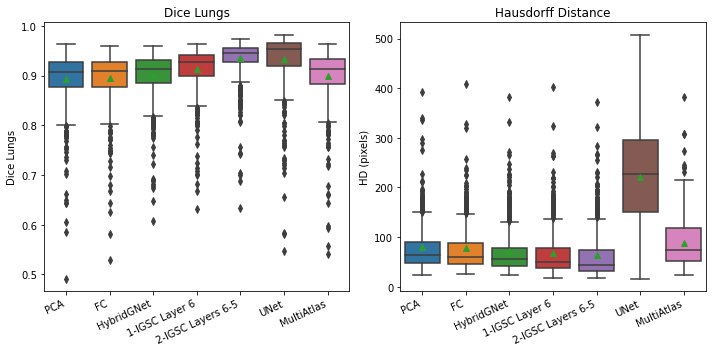

Dice
PCA 0.894 +- 0.054
FC 0.895 +- 0.051
HybridGNet 0.901 +- 0.047
1-IGSC Layer 6 0.914 +- 0.044
2-IGSC Layers 6-5 0.935 +- 0.038
UNet 0.933 +- 0.055
MultiAtlas 0.900 +- 0.054

Hausdorff
PCA 79.123 +- 47.736
FC 77.111 +- 48.155
HybridGNet 72.136 +- 47.400
1-IGSC Layer 6 67.388 +- 48.534
2-IGSC Layers 6-5 64.471 +- 51.535
UNet 220.894 +- 102.942
MultiAtlas 88.135 +- 48.946



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice Lungs')
plt.title('Dice Lungs')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD Lungs', data = results, showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (pixels)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
#plt.savefig('num1.png', dpi=300)
plt.show()

print('Dice')
for model in model_names:
    print(model, '%.3f'%np.mean(results['Dice Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['Dice Lungs'][results['Model'] == model]))

print('')

print('Hausdorff')
for model in model_names:
    print(model, '%.3f'%np.mean(results['HD Lungs'][results['Model'] == model]), '+- %.3f' % np.std(results['HD Lungs'][results['Model'] == model]))

print('')

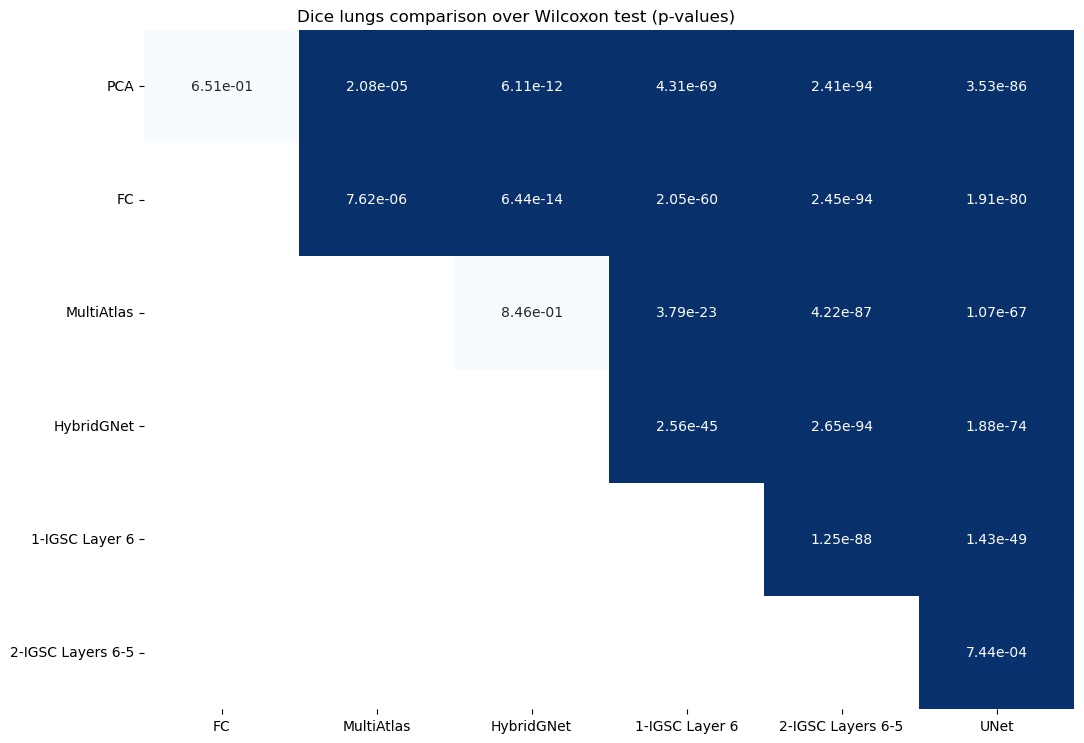

In [13]:
from scipy.stats import wilcoxon

model_names = ['PCA', 'FC', 'MultiAtlas', 'HybridGNet', '1-IGSC Layer 6', '2-IGSC Layers 6-5', 'UNet']

nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['Dice Lungs']
        mse2 = results[results['Model'] == model2]['Dice Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('Dice lungs comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/dice_wilcoxon_lungs_shenzhen.png', bbox_inches='tight')
plt.show()

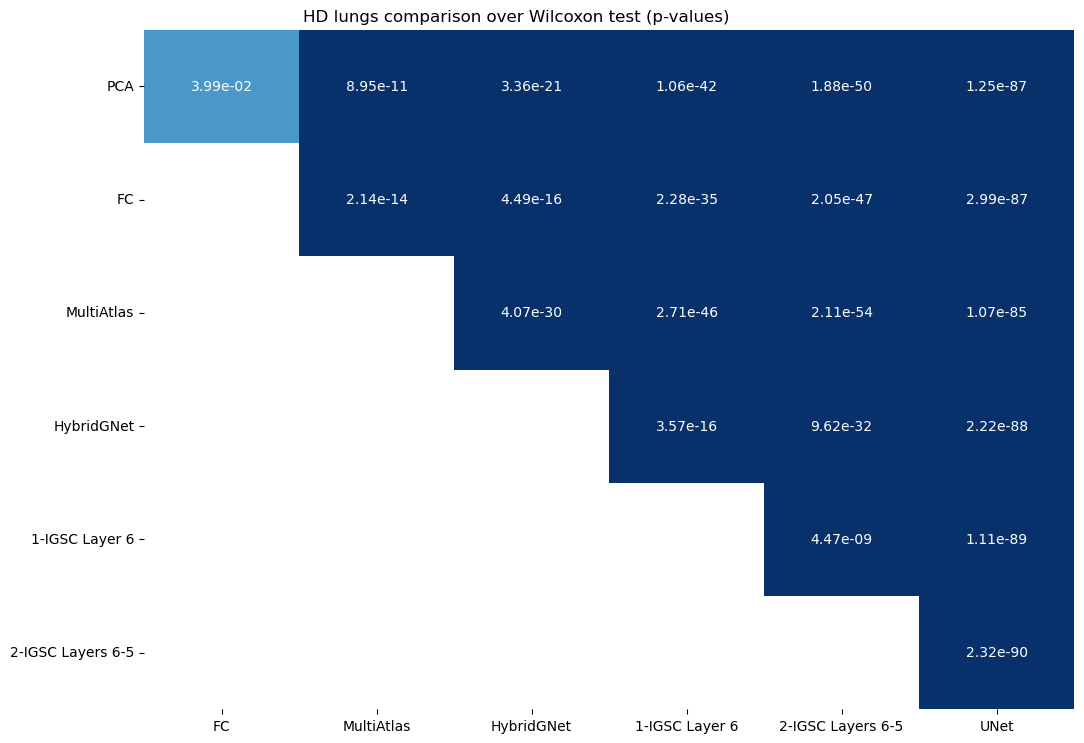

In [14]:
nmodels = len(model_names)

pvalues_mse = np.zeros([nmodels,nmodels])

for i in range(0, nmodels):
    for j in range(i+1, nmodels):
        model1 = model_names[i]
        model2 = model_names[j]
                
        mse1 = results[results['Model'] == model1]['HD Lungs']
        mse2 = results[results['Model'] == model2]['HD Lungs']
        pvalue = wilcoxon(mse1, mse2)
        
        pvalues_mse[i, j] = pvalue[1]        

pvalues_df = pd.DataFrame(pvalues_mse, columns = model_names)
pvalues_df.index = model_names

fig, ax = plt.subplots(figsize=(12, 9), dpi = 100)

# mask
mask = np.tril(np.ones_like(pvalues_df, dtype=bool))

mask = mask[:-1, 1:]
pvalues = pvalues_df.iloc[:-1,1:].copy()

# plot heatmap
sns.heatmap(pvalues, mask=mask, annot=True, fmt=".2e", cmap='Blues_r',
            vmin=0, vmax=0.1, cbar = False)
# yticks
plt.yticks(rotation=0)
plt.title('HD lungs comparison over Wilcoxon test (p-values)', x = 0.4)

plt.savefig('figs/HD_wilcoxon_lungs_shenzhen.png', bbox_inches='tight')
plt.show()

/home/ngaggion/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngaggion/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


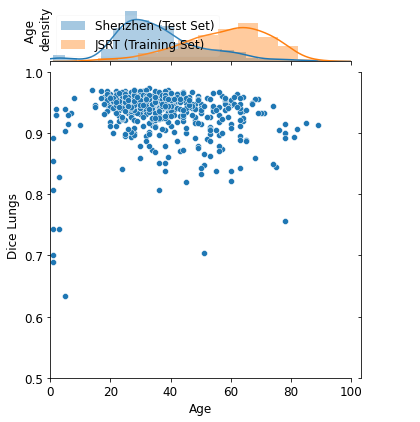

In [17]:
plt.rcParams.update({'font.size': 12})

JSRT = pd.read_csv('../Datasets/JSRT/Clinical_Information/JSRT_train_clinical.csv')
res = results[results["Model"] == "2-IGSC Layers 6-5"]

g = sns.JointGrid(x='Age', y='Dice Lungs', data = res)

sns.distplot(x = res["Age"], ax=g.ax_marg_x, label = 'Shenzhen (Test Set)')
sns.distplot(x = JSRT['Age'], ax=g.ax_marg_x, label = 'JSRT (Training Set)')

g.plot_joint(sns.scatterplot)
plt.ylim(0.5, 1.0)
g.ax_joint.set_xlim(0, 100)

g.ax_marg_x.legend(loc = 'upper left', fancybox=True, framealpha=0.1)

plt.text(-6.5, 1.04, "  Age \ndensity", rotation = 90)

plt.savefig('figs/ages_shenzhen_dice.png', dpi = 250, bbox_inches='tight')
plt.savefig('figs/ages_shenzhen_dice.pdf', dpi = 250, bbox_inches='tight')

/home/ngaggion/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngaggion/anaconda3/envs/torch/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


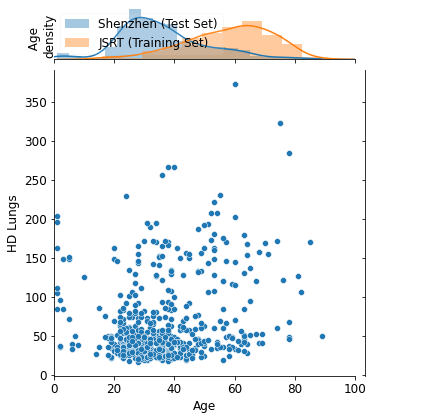

In [18]:
g = sns.JointGrid(x='Age', y='HD Lungs', data = res)

sns.distplot(x = res["Age"], ax=g.ax_marg_x, label = 'Shenzhen (Test Set)')
sns.distplot(x = JSRT['Age'], ax=g.ax_marg_x, label = 'JSRT (Training Set)')

g.plot_joint(sns.scatterplot)
g.ax_joint.set_xlim(0, 100)

g.ax_marg_x.legend(loc = 'upper left', fancybox=True, framealpha=0.1)

plt.text(-6.5, 410, "  Age \ndensity", rotation = 90)

plt.savefig('figs/ages_shenzhen_hd.png', dpi = 250, bbox_inches='tight')
plt.savefig('figs/ages_shenzhen_hd.pdf', dpi = 250, bbox_inches='tight')